# Introduction à pytorch

In [153]:
import torch
import torch.nn.functional as F
from torch.autograd import grad
from copy import deepcopy

## I) Les tenseurs

L'outil central de la librairie et la classe torch.Tensor qui permet de faire des calculs vectorizés et être indéxé à la manière d'une array numpy.
C'est un bloc contigue de mémoire qui contient des données typées, et est découpé en plusieurs dimensions. En plus du type de données, on peut définir si le tenseur requiert la propagation du gradient, et l'appareil sur lequel les données sont stockées et où les opérations seront effectuées ("cpu" ou "cuda:i").

In [4]:
t = torch.tensor([[1, 5], [3, 2]], dtype=torch.float32, requires_grad=False, device="cpu")  # la fonction "torch.tensor" permet de créer un tenseur de manière analogue à "np.array"
print(repr(t))

tensor([[1., 5.],
        [3., 2.]])


In [5]:
2*t - t**0.5 + 2  # Les opérations usuelles en numpy sont disponibles

tensor([[3.0000, 9.7639],
        [6.2679, 4.5858]])

In [6]:
(t.shape, t.dtype, t.requires_grad, t.device)  # les attributs usuels des array numpy sont nommées de manière identiques

(torch.Size([2, 2]), torch.float32, False, device(type='cpu'))

In [7]:
t[1, 1], t[:, 1], t[..., 0], t[0], t[:, :1]  # Les syntaxes d'indentation sont identiques à celles de numpy

(tensor(2.),
 tensor([5., 2.]),
 tensor([1., 3.]),
 tensor([1., 5.]),
 tensor([[1.],
         [3.]]))

Toutes les opérations usuelles de la librairie numpy existent dans pytorch (ou presque). Si le tenseur est sur un GPU, le calcul sera effectué de manière parallélisée sur GPU, ce qui peut très largement accélérer la vitesse d'execution pour des tenseurs de grande taille.

In [8]:
t.min(), t.mean(dim=1), t.max(), t.std(dim=0)  # les méthodes usuelles des array numpy sont nommées de manière identiques. Le kwargs "ax" est renommé "dim".

(tensor(1.), tensor([3.0000, 2.5000]), tensor(5.), tensor([1.4142, 2.1213]))

In [9]:
t @ -t  # Les opérateur aux sens spécifiques en numpy sont aussi implémentés. Ici équivalent à "torch.matmul(t, -t)".

tensor([[-16., -15.],
        [ -9., -19.]])

In [10]:
torch.exp(-t**2 + 2)  # les fonctions mathématiques courantes sont disponibles dans le namespace "torch"

tensor([[2.7183e+00, 1.0262e-10],
        [9.1188e-04, 1.3534e-01]])

In [11]:
F.elu(-t)  # Les fonctions liées à des opérations propres aux réseaux de neurones (loss, convolutions, activation, ...) se trouvent dans le namespace "torch.nn.functional"

tensor([[-0.6321, -0.9933],
        [-0.9502, -0.8647]])

In [12]:
torch.linalg.inv(t)  # Les fonctions d'algèbre linéaires de numpy sont implémentées dans le namespace "torch.linalg". Ici une opération d'inversion matricielle (dont on peut obtenir le gradient !)

tensor([[-0.1538,  0.3846],
        [ 0.2308, -0.0769]])

In [13]:
torch.rand((1,)), torch.randint(0, 3, (1,)), torch.normal(0., 1., (1,))  # Les fonctions de génération de nombres aléatoires ne sont pas (contrairement à numpy) dans le namespace torch.random !

(tensor([0.9228]), tensor([1]), tensor([-0.1564]))

Tout comme les arrays numpy, on peut réorganiser la taille des dimensions (sans que la taille totale du tenseur ne change) ou l'ordre des dimensions

In [14]:
t = torch.arange(2*3*3, dtype=torch.long).reshape(3, 2, 3)
print(repr(t))

tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]],

        [[12, 13, 14],
         [15, 16, 17]]])


In [15]:
t.transpose(1, 2)  # inverse l'ordre des dimensions 1 et 2

tensor([[[ 0,  3],
         [ 1,  4],
         [ 2,  5]],

        [[ 6,  9],
         [ 7, 10],
         [ 8, 11]],

        [[12, 15],
         [13, 16],
         [14, 17]]])

In [16]:
t.permute(1, 0, 2)  # permute l'ordre de toutes les dimensions dans l'ordre spécifié

tensor([[[ 0,  1,  2],
         [ 6,  7,  8],
         [12, 13, 14]],

        [[ 3,  4,  5],
         [ 9, 10, 11],
         [15, 16, 17]]])

In [148]:
t.unsqueeze(0).shape  # la méthode "unsqueeze" permet de créer des dimensions vide

torch.Size([1, 4])

In [149]:
t.unsqueeze(0).squeeze(0).shape  # la méthode "squeeze" à l'inverse permet de retirer une dimension vide

torch.Size([4])

## II) création du graph de calcul

Lorsqu'un tenseur requiert la propagation du gradient, le graphe de calcul est créé dynamiquement, de manière transparente pour l'utilisateur, lorsqu'on effectue des opérations, le résultat renvoyé est un nouveau tenseur lié au précédent par une branche du graphe deu calcul. Pour cette raison, il ne faut jamais modifier manuellement le contenu des tenseurs à travers lesquels on compte propager le gradient.

In [43]:
t = torch.arange(4, dtype=torch.float32, requires_grad=True)
print(repr(t))

tensor([0., 1., 2., 3.], requires_grad=True)


In [44]:
r = torch.sum(t**2)  # notez la présence de la "grad_fn" (gradient function) qui a donné lieu au nouveau tenseur.
print(repr(r))

tensor(14., grad_fn=<SumBackward0>)


In [45]:
grad(r, t, retain_graph=True)  # la fonction "grad" permet de calculer le gradient d'un scalaire par apport à un tenseur donné

(tensor([0., 2., 4., 6.]),)

In [46]:
r.backward()  # la méthode "backward" permet de propager le gradient dans tous le graph
print(repr(t.grad))  # on retrouve la solution analytique de la dérivée de la somme des carrés (y = 2*x), évaluées en [0, 1, 2, 3].

tensor([0., 2., 4., 6.])

In [47]:
# Une fois le gradient propagé, les résultats intermédiaires du graph de calcul sont supprimés pour libérer de la mémoire.
# On ne peut pas appeler backward une deuxième fois
try:
    r.backward()
except Exception as e:
    print(str(e))

Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.


In [50]:
t = torch.arange(4, dtype=torch.float32, requires_grad=True)
r = torch.sum(t**2)  # appeler "backward" avec le flag "retain_graph" à "True" permet de ne pas effacer le graphe de calcule.
r.backward(retain_graph=True)
r.backward()
print(repr(t.grad))  # On remarque alors que pytorch "accumule" les gradients au lieux d'écrire la nouvelle valuer par dessus l'acienne.


tensor([ 0.,  4.,  8., 12.])


In [97]:
# Utiliser un contexte "torch.no_grad()" permet de ne pas construire le graph de calcul, et donc d'économiser la mémoire, et d'accélérer le calcul
t = torch.arange(4, dtype=torch.float32, requires_grad=True)
with torch.no_grad():
    r = torch.sum(t**2)
print(r.requires_grad)

False


## III) Les Modules pytorch

Dans pytorch une brique de modèle (une couche d'un modèle feed forward, ...) comme un modèle entier dérivent de la classe Module.
Les classes filles doivent implémenter la fonction "forward" qui correspond à la passe avant de la couche/du modèle (aka: l'opération effectuée)

In [98]:
lin = torch.nn.Linear(2, 3)  # certaines couches courrament utilisées sont déjà implémentées

In [99]:
help(lin)  # La couche linéaire (y = x@A.T + b) attend en entrée un tenseur de shape (n_observations, features_in) et renvoit un tenseur de shape (n_observations, features_out)

Help on Linear in module torch.nn.modules.linear object:

class Linear(torch.nn.modules.module.Module)
 |  Linear(in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None
 |  
 |  Applies a linear transformation to the incoming data: :math:`y = xA^T + b`
 |  
 |  This module supports :ref:`TensorFloat32<tf32_on_ampere>`.
 |  
 |  Args:
 |      in_features: size of each input sample
 |      out_features: size of each output sample
 |      bias: If set to ``False``, the layer will not learn an additive bias.
 |          Default: ``True``
 |  
 |  Shape:
 |      - Input: :math:`(*, H_{in})` where :math:`*` means any number of
 |        dimensions including none and :math:`H_{in} = \text{in\_features}`.
 |      - Output: :math:`(*, H_{out})` where all but the last dimension
 |        are the same shape as the input and :math:`H_{out} = \text{out\_features}`.
 |  
 |  Attributes:
 |      weight: the learnable weights of the module of shape
 |          :math:`

In [80]:
r = lin(torch.rand(10, 2))  # on peut appliquer l'opération correspondante en utilisant l'opérateur __call__
print(repr(r.shape))

torch.Size([10, 3])


In [70]:
list(lin.parameters())  # on peut obtenir un itérable des paramètres d'un module ave cla méthode "parameters"

[Parameter containing:
 tensor([[ 0.6629, -0.2114],
         [-0.5893, -0.4619],
         [ 0.1115,  0.2443]], requires_grad=True),
 Parameter containing:
 tensor([-0.0919,  0.0999, -0.4083], requires_grad=True)]

In [84]:
from typing import Callable

class Layer(torch.nn.Module):
    """
    Un objet 'Layer' est une couche cachée d'un réseau feed forward
    """

    def __init__(self, in_features: int, out_features: int, activation: Callable):
        """
        Parameters
        ----------
        in_features : int
            number of features in input tensors
        out_features : int
            number of features in output
        activation : Callable
            activation function applied after linear projection and batch normalization
        
        Returns
        -------
        torch.Tensor :
            tensor of shape (N, H_out)
        """
        super().__init__()
        self.linear = torch.nn.Linear(in_features, out_features)
        self.batch_norm = torch.nn.BatchNorm1d(out_features)
        self.activation = activation

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        X : torch.Tensor
            tensor of shape (N, H_in)
        
        Returns
        -------
        torch.Tensor :
            tensor of shape (N, H_out)
        """
        X = self.linear(X)
        X = self.batch_norm(X)
        X = self.activation(X)
        return X

In [85]:
class FeedForwardRegressor(torch.nn.Module):
    """
    Un objet 'FeedForwardRegressor' est un modèle feed forward pour la régression
    """

    def __init__(self, in_features: int, hidden_features: list[int], activation: Callable = F.relu):
        super().__init__()
        self.hidden_layers = torch.nn.ModuleList()
        for out_features in hidden_features:
            self.hidden_layers.append(Layer(in_features, out_features, activation))
            in_features = out_features
        self.output_projection = torch.nn.Linear(out_features, 1)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        X : torch.Tensor
            tensor of shape (N, H_in)
        
        Returns
        -------
        torch.Tensor :
            tensor of shape (N, H_out)
        """
        for layer in self.hidden_layers:
            X = layer(X)
        X = self.output_projection(X)
        return X

In [88]:
ffr = FeedForwardRegressor(2, [10, 10, 10])
ffr(torch.rand(10, 2))

tensor([[ 0.1860],
        [ 0.2241],
        [-0.1515],
        [ 0.1256],
        [ 0.3666],
        [-0.1342],
        [-0.1281],
        [ 0.4924],
        [ 0.1901],
        [ 0.0177]], grad_fn=<AddmmBackward0>)

In [94]:
list(ffr.children())  # On peut récupérer un itérable sur les sous modules avec la méthode "children"

[ModuleList(
   (0): Layer(
     (linear): Linear(in_features=2, out_features=10, bias=True)
     (batch_norm): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): Layer(
     (linear): Linear(in_features=10, out_features=10, bias=True)
     (batch_norm): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (2): Layer(
     (linear): Linear(in_features=10, out_features=10, bias=True)
     (batch_norm): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
 ),
 Linear(in_features=10, out_features=1, bias=True)]

In [91]:
len(list(ffr.parameters()))  # La méthode "parameter" renvoit aussi les groupes de paramètres des sous modules

14

In [125]:
# Certains Modules ne doivent pas avoir le même comportement lors de l'entraînement et de l'évaluation.
# Un flag permet de déterminer si le module est en mode entraînement ou évaluation
dropout = torch.nn.Dropout(p=0.5)
dropout.training

True

In [126]:
# on peut passer un module (et ses sous modules recursivement) en mode entraînement avec la méthode "train"
dropout.train()
dropout(torch.rand(3, 3))

tensor([[1.3370, 0.0000, 1.3393],
        [0.0981, 0.0000, 1.0729],
        [0.3315, 0.0000, 0.0000]])

In [127]:
# on peut passer un module (et ses sous modules recursivement) en mode entraînement avec la méthode "eval"
dropout.eval()
dropout(torch.rand(3, 3))

tensor([[0.6677, 0.6850, 0.6416],
        [0.5843, 0.8619, 0.8826],
        [0.4001, 0.0346, 0.7978]])

## IV) La boucle d'entraînement

In [132]:
import matplotlib.pyplot as plt

In [144]:
def y(x: torch.Tensor) -> torch.Tensor:
    return x**2 + torch.normal(0., 0.1, x.shape)

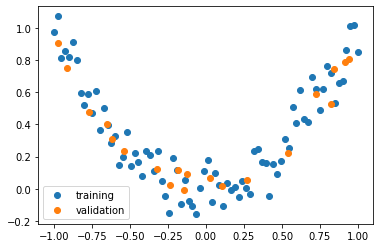

In [157]:
x_train = torch.linspace(-1., 1., 80).unsqueeze(1)
y_train = y(x_train)
x_val = torch.rand((20, 1)) * 2 - 1
y_val = y(x_val)
plt.scatter(x_train.reshape(-1).tolist(), y_train.reshape(-1).tolist(), label="training")
plt.scatter(x_val.reshape(-1).tolist(), y_val.reshape(-1).tolist(), label="validation")
plt.legend()

In [234]:
def loss_function(y_pred: torch.Tensor, y_target: torch.Tensor) -> torch.Tensor:
    """
    returns the mean squared error loss

    Parameters
    ----------
    y_pred : torch.Tensor
        tensor of shape (N,)
    y_target : torch.Tensor
        tensor of shape (N,)
    
    Returns
    -------
    torch.Tensor :
        scalar tensor
    """
    return F.mse_loss(y_pred, y_target)

In [235]:
def train_loop(model: torch.nn.Module, optimier: torch.optim.Optimizer, train_data: tuple[torch.Tensor], val_data: tuple[torch.Tensor], loss_function: Callable, n_steps: int = 100, patience: int = 20):
    """
    performs the training for a given number of iterations
    """
    x_train, y_train = train_data
    x_val, y_val = val_data
    best_metric = float("inf")
    best_step = 0
    checkpoint = deepcopy(model.state_dict())
    for step in range(100):
        # setting the gradient to zero to avoid gradient accumulation
        optimizer.zero_grad()
        # training
        model.train()
        loss = loss_function(model(x_train), y_train)
        loss.backward()
        # validation
        model.eval()
        with torch.no_grad():
            metric = loss_function(model(x_val), y_val).item()
        if metric < best_metric:
            best_step = step
            checkpoint = deepcopy(model.state_dict())
        elif step - best_step == patience:
            model.load_state_dict()
            print("early stopping")
            return
        # printing progress
        print(f"Step {step}: loss = {loss.item():.3g}, metric = {metric:.3g}", flush=True)
        # step of the optimizer
        optimizer.step()

In [242]:
# Le namespace "optim" contient les différents algorithmes d'optimisation
ffr = FeedForwardRegressor(1, [10, 10])
optimizer = torch.optim.Adam(ffr.parameters(), lr=1.0E-2)
train_loop(ffr, optimizer, (x_train, y_train), (x_val, y_val), loss_function)

Step 0: loss = 0.24, metric = 0.169
Step 1: loss = 0.0994, metric = 0.152
Step 2: loss = 0.061, metric = 0.143
Step 3: loss = 0.036, metric = 0.136
Step 4: loss = 0.0258, metric = 0.133
Step 5: loss = 0.0195, metric = 0.133
Step 6: loss = 0.0161, metric = 0.137
Step 7: loss = 0.0148, metric = 0.144
Step 8: loss = 0.0175, metric = 0.151
Step 9: loss = 0.0197, metric = 0.158
Step 10: loss = 0.0208, metric = 0.165
Step 11: loss = 0.0214, metric = 0.171
Step 12: loss = 0.0219, metric = 0.173
Step 13: loss = 0.0217, metric = 0.175
Step 14: loss = 0.0209, metric = 0.176
Step 15: loss = 0.0197, metric = 0.177
Step 16: loss = 0.0184, metric = 0.177
Step 17: loss = 0.017, metric = 0.177
Step 18: loss = 0.0157, metric = 0.178
Step 19: loss = 0.0146, metric = 0.179
Step 20: loss = 0.0137, metric = 0.179
Step 21: loss = 0.0131, metric = 0.179
Step 22: loss = 0.0127, metric = 0.179
Step 23: loss = 0.0127, metric = 0.177
Step 24: loss = 0.0127, metric = 0.173
Step 25: loss = 0.013, metric = 0.169
St

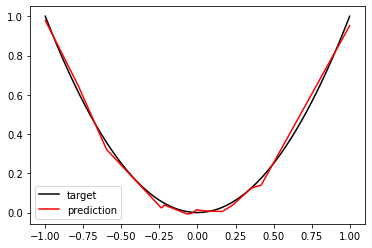

In [247]:
x_test = torch.linspace(-1, 1, 1000)
y_target = x_test**2
y_pred = ffr(x_test.unsqueeze(-1)).squeeze(-1)
plt.plot(x_test.tolist(), y_target.tolist(), color="k", label="target")
plt.plot(x_test.tolist(), y_pred.tolist(), color="r", label="prediction")
plt.legend()